
## <center>ДЕТЕКЦИЈА НА КАНЦЕРОГЕНИ КЛЕТКИ СО ПОМОШ НА НАНОРОБОТ И АЛГОРИТАМ ЗА УЧЕЊЕ СО ПОТТИКНУВАЊЕ</center>


## Содржина

0. [Вовед](#voved)
1. [Воведување на потребните библиотеки](#lib)
2. [Опис на околината за тренирање](#env)
   - [Функција __init__](#init)
   - [Функција generate_cancer_cells](#cells)
   - [Функција generate_obstacles](#obs)
   - [Функција biomarker_concentration](#bio)
   - [Функција is_collision](#col)
   - [Функција get_obs](#obs2)
   - [Функција reset](#reset)
   - [Функција step](#step)
4. [Тренирање на агентот](#train)
   - [Објаснување на применетиот алгоритам Proximal policy optimization](#ppo)
    
6. [Визуелизација при тестирање](#test)

## 0. Вовед <a id='voved'></a>

Во овој проект е разгледан концептот на нанороботи – микро или нано размерни автономни уреди кои можат да се движат низ биолошки средини и да вршат задачи како што е идентификација на канцерогени клетки. За да се овозможи автономно движење и донесување одлуки во сложени средини, нанороботите се контролираат преку алгоритми за учење со поттикнување (Reinforcement Learning). Овој пристап им овозможува на агентите (нанороботите) да учат од искуство, да откриваат оптимални стратегии за навигација и да максимизираат својата ефективност во детекција на целни клетки.

Целта на проектот е да се креира симулирана 3D околина во која нанороботот ќе се движи и преку алгоритамот PPO (Proximal Policy Optimization) ќе научи како да детектира канцерогени клетки, избегнувајќи пречки, и да се евалуира неговото учење преку анализа на вкупните награди по епизода. Проектната задача се фокусира на развој на симулирана 3D околина каде нанороботот може автономно да се движи и да идентификува канцерогени клетки. За оваа намена е креирана околина во Python користејќи ја библиотеката Gymnasium, која овозможува дефинирање на агенти, простори за акции и набљудување, како и правила за симулација.

Во следните секции од проектната задача ќе биде приложен кодот за реализација на околината за тренирање на агентот, како и соодветните кодови за функциите кои се користат за тренирање и визуелизација на она што агентот го научил во текот на тренирањето.

## 1. Воведување на потребните библиотеки <a id='lib'></a>

In [1]:
import random
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import plotly.graph_objects as go
from ipywidgets import Button, HBox, FloatSlider, Label
from IPython.display import display
import time
from stable_baselines3 import PPO

2025-09-27 01:22:21.580678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758928941.827984    3526 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758928941.881469    3526 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758928942.411208    3526 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758928942.411247    3526 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758928942.411251    3526 computation_placer.cc:177] computation placer alr

Во овој проект користиме повеќе Python библиотеки,а нивните улога во изработка на проектна задача се дадени во прилог:

- **random**  
  Се користи за генерирање на случајни броеви и избор на случајни акции.  

- **numpy (np)**   
  Се користи за пресметки како растојание помеѓу агент и цел и анализа на резултати.

- **gymnasium (gym) и gymnasium.spaces**  
  Gymnasium е стандардна библиотека за дефинирање околини за учење со поттикнување.  
  Со `spaces` се дефинира просторот на акции (action space) и просторот на набљудувања (observation space).

- **plotly.graph_objects (go)**  
  Се користи за интерактивни визуелизации.  

- **ipywidgets (Button, HBox, FloatSlider, Label) и IPython.display**  
  Овозможуваат додавање интерактивни елементи во Jupyter тетратката.  
  На пример, копчиња и слајдери за интерактивна контрола на симулацијата.

- **time**  
  Се користи за паузи или мерење на време.  
  На пример, додавање кратко доцнење помеѓу чекорите при визуелизација.

- **stable_baselines3.PPO**  
  Библиотека со имплементации на алгоритми за учење со поттикнување.  
  `PPO` (Proximal Policy Optimization) е алгоритам кој се користи за тренирање на агентот.  
  Тој е стабилен и добро прилагоден особено за сложени околини.


## 2. Опис на околината за тренирање <a id='env'></a>

## Околина: NanoRobotEnv

Оваа околина е специјално изработена за симулација на **наноробот во тридимензионален простор** со цел детекција на канцерогени клетки.  
Наноробот се движи во простор со дефинирана големина и има способност да детектира **биомаркерска концентрација**, која претставува индикатор за близина до канцерогени клетки.  

### Карактеристики на околината
- **Простор**: Тродимензионален простор со димензии `space_size × space_size × space_size`.  
- **Агент (наноробот)**: Се движи низ просторот и избира акции за поместување во три насоки (x, y, z).  
- **Канцерогени клетки**: Случајно распоредени низ просторот; тие се целта на агентот.  
- **Пречки**: Случајно генерирани објекти (обstacles) кои агентот мора да ги избегнува.  
- **Биомаркерска концентрација**: Се пресметува како функција од растојанието до најблиската канцерогена клетка и ја води понатамошната акција на агентот.  
- **Акции**: Континуирани вредности (x, y, z) во опсег [-1, 1], кои се множат со `step_size` за да се добие новата позиција на агентот.  
- **Набљудувања**: Состојат од моменталната позиција на агентот `(x, y, z)` и претходната концентрација на биомаркерот.  
- **Награди**:  
  - +10 при успешна детекција на канцерогена клетка,  
  - -1 при судир со пречка,  
  - +2 ако концентрацијата на биомаркерот се зголеми (агентот се движи во правилна насока),  
  - -0.2 ако концентрацијата се намали (агентот се движи во погрешна насока).  

### Главни методи
- **`__init__`**: иницијализирање на просторот, клетките, пречките и акциските/набљудувачките простори.  
- **`generate_cancer_cells`**: поставување на канцерогените клетки во просторот.  
- **`generate_obstacles`**: креирање на пречки околу кои агентот треба да научи да се движи и да ги избегнува.  
- **`biomarker_concentration`**: пресметка на концентрација како функција од растојание.  
- **`is_collision`**: проверка дали агентот се судрил со пречка.  
- **`get_obs`**: враќа моментална состојба на околината.  
- **`reset`**: ресетирање на епизода (нова почетна позиција).  
- **`step`**: извршување на акција, ажурирање на позицијата и пресметка на наградата.  


![](newplot(1).png)


In [2]:
class NanoRobotEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 10}

    def __init__(self, space_size=50, sigma=5, num_obstacles=30,
                 obstacle_radius=3, num_cancer_cells=10, step_size=1.5):
        super().__init__()
        
#Се превземаат параметрите од погоре како карактеристики на објектот за да може да се користат во понатамошните функции
        self.space_size = space_size
        self.sigma = sigma
        self.obstacle_radius = obstacle_radius
        self.num_obstacles = num_obstacles
        self.num_cancer_cells = num_cancer_cells
        self.step_size = step_size
        
# Action и observation space на агентот 
        self.action_space = spaces.Box(low=-1, high=1, shape=(3,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=space_size, shape=(4,), dtype=np.float32)

        self.generate_cancer_cells() #ги поставува целните клетки во просторот
        self.generate_obstacles() # креира пречки кои агентот треба да ги одмине
        self.reset() # го иницијализира агентот на нова почетна позиција и ја пресметува првата биомаркерска концентрација

# Фунцкија за генерирање позиции на сите канцерогени клетки во просторот
    def generate_cancer_cells(self):
        self.cancer_cells = [np.array([random.uniform(0, self.space_size) for _ in range(3)]) # креира 3D координати за секоја клетка и избира случајна точка во опсегот од 0 до space_size за секоја клетка
                             for _ in range(self.num_cancer_cells)] # ги зачувува сите клетки во листа која агентот ја користи за пресметка на биомаркерска концентрација

# Функција за генерирање позиции на пречки кои агентот учи да ги избегнува
    def generate_obstacles(self):
        self.obstacles = [] #листа каде се чуваат сите позиции на пречките
        for _ in range(self.num_obstacles): # се повторува циклусот онолку пати колку е зададено во параметарот
            while True:
                pos = np.array([random.uniform(0, self.space_size) for _ in range(3)]) # се генерира случајна позиција за секоја пречка
                if all(np.linalg.norm(pos - c) > self.obstacle_radius + 5 for c in self.cancer_cells): # услов за безбедна поставеност
                    self.obstacles.append(pos) # ако е исполнет условот позицијата се додава во листата
                    break

# Концентрација на биомаркери за проценка на растојание до канцер клетка
    def biomarker_concentration(self, pos):
        dists_sq = [np.sum((pos - c) ** 2) for c in self.cancer_cells] # пресметка на растојание од тековнната позиција на агентот до клетка с (квадрат на секоја координата)
        return np.exp(-min(dists_sq) / (2 * self.sigma ** 2)) # гаусова функција (bell curve)
# се формира листа со квадратите на растојанијата до сите канцерогени клетки


# Функција за прверка дали агентот удрил во пречка
    def is_collision(self, pos): # на влез ја имаме позицијата на агентот
        return any(np.linalg.norm(pos - o) <= self.obstacle_radius for o in self.obstacles)  #проверка на растојанија до сите пречки
#проверува дали барем една пречка е доволно блиску за да предизвика судир, враќа true ако има, инаку false

# Состојбена функција за секој чекор
    def get_obs(self):
        return np.array([*self.pos, self.prev_concentration], dtype=np.float32)  #се пресметува моменталната позиција на агентот и последната пресметана биомаркерска концентрација на таа позиција

   
    # Gymnasium-compatible функции

# Фунцкија за поставување на почетната состојба на околината
    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed) #се повикува основната Gym функција за reset
        if seed is not None: # ако се внесе seed тогаш секогаш ќе се добиваат исти почетни позиции за тестирање.
            np.random.seed(seed)
            random.seed(seed)

        while True:
            self.pos = np.array([random.uniform(0, self.space_size) for _ in range(3)])   # се бара случајна почетна позиција на агентот 
            if not self.is_collision(self.pos): # циклусот продолжува додека не се најде позиција које е надвор од сите пречки
                break

        self.prev_concentration = self.biomarker_concentration(self.pos) # се пресметува почетната биомаркерска концентрација
        return self.get_obs(), {} # се враќа првото набљуду7вање (позиција + концентрација)

        
# Функција за пресметка на награда и следни чекор по некоја акција
    def step(self, action):
        action = np.clip(action, -1, 1) #проверува дали акцијата е во дадениот опсег
        new_pos = np.clip(self.pos + action * self.step_size, 0, self.space_size) # се пресметува новата позиција врз основа на акцијата и големината на чекор (step_size)

        reward = 0 # зададени почетни вредности, се менуваат подоцна
        done = False # зададени почетни вредности, се менуваат подоцна

        if self.is_collision(new_pos):
            reward = -1 # ако новата позиција се судри со пречка агентот добива казна -1
        else:
            concentration = self.biomarker_concentration(new_pos) # инаку се пресметува биомаркерската концентрација на новата позиција
            done = any(np.linalg.norm(new_pos - c) < 2 for c in self.cancer_cells)

        # Награда/ казна
            reward = 10 if done else (2 if concentration > self.prev_concentration else -0.2) #   добива награда 10 ако е пронајдена канцер клетка или е премногу блиску до неа
            # +2 ако концентрацијата се зголемила од претходниот чекор (значи се движи во добра насока)
            # -0.2 ако концентрацијата се намалила (значи оди во погрешна насока)
            self.pos = new_pos # се обновува позицијата на агентот
            self.prev_concentration = concentration # се обновува концентрацијата на новата позиција

        return self.get_obs(), reward, done, False, {} # се враќаат набњудувањата, наградата и дали е завршена епизодата

**ОБЈАСНУВАЊЕ НА ФУНКЦИИ**

## ФУНКЦИЈА _init_ <a id='init'></a>

Оваа функција е иницијализаторот на класата, се повикува секогаш кога ќе се создаде објект од околината. Во продолжение се дадени параметрите од кои се содржи како и нивно објаснување:

- `space_size=50` → големината на тродимензионален простор (x, y, z)
- `sigma=5` → параметар за „распрскување“ на биомаркерската концентрација (колку е поблиску до целта, повисока е концентрацијата)
- `num_obstacles=30` → број на пречки
- `obstacle_radius=3` → радиус на пречките (колку се „големи“)
- `num_cancer_cells=10` → број на канцерогени клетки во просторот
- `step_size=1.5` → колкав чекор прави агентот по една акција
- `super().__init__()` → повикување на класата `gym.Env` за да се иницијализира Gym-структурата.
  
Од сите овие параметри најважен за понатамошното тренирање на агентот е параметарот sigma, чија вредност му помага на агентот да препознае канцерогена клетка од различни растојанија. Таа се пресметува како:
$$
C = \exp\Big(-\frac{d^2}{2 \sigma^2}\Big)
$$
каде:
- d е растојанието од агентот до најблиската канцерогена клетка,  
- sigma ја контролира ширината на сигналот (од колку далеку агентот може да почувствува канцерогена клетка.

**Аction space** го прикажува просторот на акции кои може да ги преземе агентот. Се работи за континуирани акции во три насоки(x,y,z) и секој елемент е во опсег од [-1,1], што значи дека агентот може да избере било која вредност во тој опсег за негови чекори, не само дискретни. За да се добие вистинско поместување во просторот, оваа вредност се множи со step_size.

**Observation space** ja прикажува состојбата на околината што агентот може да ја види во секој чекор. Таа е изградена од тековната позиција на агентот (x,y,z) и претходната биомаркерска концентрација.

## ФУНКЦИЈА generate_cancer_cells <a id='cells'></a>

Важно да се напомене за оваа функција е дека позициите на клетките се нови и случајни секој пат кога повторно ќе се повика функцијата. Ова ја прави околината динамична и обезбедува дека агентот мора да учи како да се движи кон целните клетки, а не да ги памти фикцните позиции, бидејќи неговата цел е да ги детектира клетките користејќи го сигналот од биомаркерот. 

## ФУНКЦИЈА generate_obstacles <a id='obs'></a>

При генерирање на случајна позиција за секоја пречка во 3D просторот потребно е да бидат задоволени одредени услови за нивна поставеност со цел да помогнат при тренирање на агентот. За секоја една пречка, се генерира внатрешен while циклус кој трае се додека не се најде валидна позиција за пречката која ги задоволува условите. Условот за безбедна поставеност на пречката е прикажан преку евклидовото растојание помеѓу пречката (pos) и секоја канцерогена клетка (с). Тој  проверува дали секоја пречка е доволно оддалечена од сите клетки. Минималната дистанца мора да биде поголема од радиусот на пречката + 5. Со ова се спречува пречките да се создадат премногу блиску до целните клетки за да не станат недостижни истите.

## ФУНКЦИЈА biomarker_concentration <a id='bio'></a>

Оваа функција е една од најважните бидејќи дефинира како агентот чувстува дека е блиску до целта. Кога се пресметува растојанието до клетката од агентот, се зема најмалото растојание, што значи дека агентот ја чувствува само најблиската клетка. Со помош на Гаусовата функција се пресметува концентрацијата на биомаркери и големината на сигма покажува од колку далеку ќе може агентот да почувствува дека некаде во близина има канцерогена клетка. Оваа функција е на некој начин сензор за агентот, но наместо директно да му каже каде е целта, тој добива концентрација на сигнал зависна од растојанието до целта. Така учењето станува пореалистично, бидејќи агентот мора да научи да се движи по градиент на концентрацијата.

## ФУНКЦИЈА is_collision <a id='col'></a>

Со помош на векторот од агентот до пречка о се пресметува Евклидова дистанца за да се добие растојанието од агентот до секоја пречка. Ако агентот се наоѓа во радиус на пречката (или на самата граница) се смета дека има судир. Оваа функција му кажуа на агентот дали удрил во пречка, ако одговорот е True во step функцијата агентот добива негативна награда (-1) и не може да напредува. Ова го отежнува учењето бидејќи агентот мора да најде пат до клетките без да удира во пречките.

## ФУНКЦИЈА get_obs<a id='obs2'></a>

Оваа функција ја претставува состојбата (observation) што агентот ја добива за секој чекор. Има четири вредности- позицијата на агентот по x,y,z оските и биомаркерската концентрација на таа позиција. На база на оваа информација агентот одлучува која акција да ја преземе следна. Последната пресметана биомаркерска концнетрација на таа позиција служи како сензорска информација за колку блиску е агентот до најблиската канцерогена клетка.

## ФУНКЦИЈА reset<a id='reset'></a>

Функцијата reset ја подготвува сцената за нова епизода. Со ваквата поставеност на функцијата секогаш се гарантира дека агентот ќе започне во валидна и безбедна позиција далечу од некоја пречка. Без оваа функција агентот не би можел да започне ново тренирање или тестирање.

Seed- Во Gymnasium секоја околина наследува од gym.Env, класа која веќе има свои вградени функции за seed и restart. Seed е број кој се користи за генерирање на случајни броеви и ако е поставен на некоја вредностг, тогаш постојано ќе се добиваат исти резултати (пр. seed=42 тогаш почетните позиции за агентот и клетките ќе бидат исти секоја наредна епизода.)

## ФУНКЦИЈА step<a id='step'></a>

Функцијата step е една од најважните функции во целата симулација бидејќи во секој чекор на агентот ја пресметува новата позиција, ја пресметува концентрацијата на биомаркери и врз основа на сето тоа враќа информација за количината на наградата што ја добил агентот и дали тој треба да прдолжи да истражува или епизодата е завршена доколку тој е во близина на канцерогена клетка или ја пронашол целосно.

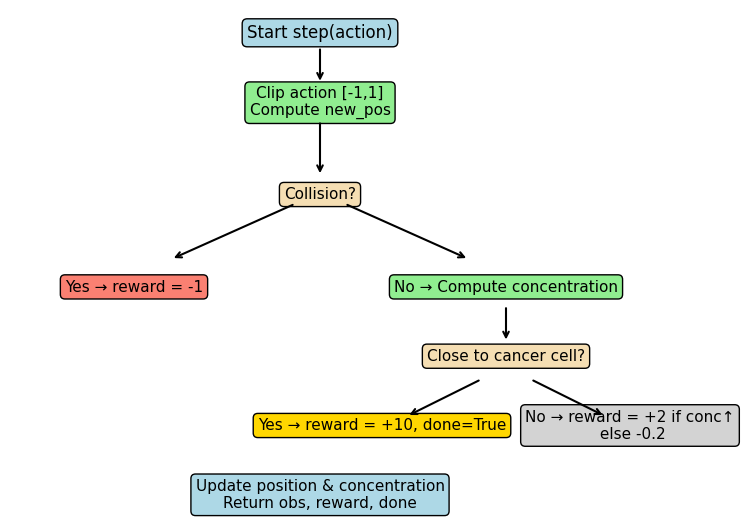

In [3]:
import matplotlib.pyplot as plt

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

# Flowchart elements
ax.text(0.5, 0.95, "Start step(action)", ha="center", va="center", fontsize=12,
        bbox=dict(boxstyle="round", facecolor="lightblue"))

ax.text(0.5, 0.8, "Clip action [-1,1]\nCompute new_pos", ha="center", va="center", fontsize=11,
        bbox=dict(boxstyle="round", facecolor="lightgreen"))

ax.text(0.5, 0.6, "Collision?", ha="center", va="center", fontsize=11,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="wheat"))

ax.text(0.2, 0.4, "Yes → reward = -1", ha="center", va="center", fontsize=11,
        bbox=dict(boxstyle="round", facecolor="salmon"))

ax.text(0.8, 0.4, "No → Compute concentration", ha="center", va="center", fontsize=11,
        bbox=dict(boxstyle="round", facecolor="lightgreen"))

ax.text(0.8, 0.25, "Close to cancer cell?", ha="center", va="center", fontsize=11,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="wheat"))

ax.text(0.6, 0.1, "Yes → reward = +10, done=True", ha="center", va="center", fontsize=11,
        bbox=dict(boxstyle="round", facecolor="gold"))

ax.text(1.0, 0.1, "No → reward = +2 if conc↑\n else -0.2", ha="center", va="center", fontsize=11,
        bbox=dict(boxstyle="round", facecolor="lightgrey"))

ax.text(0.5, -0.05, "Update position & concentration\nReturn obs, reward, done", ha="center", va="center", fontsize=11,
        bbox=dict(boxstyle="round", facecolor="lightblue"))

# Arrows
def arrow(start, end):
    ax.annotate("", xy=end, xytext=start,
                arrowprops=dict(arrowstyle="->", lw=1.5))

arrow((0.5, 0.92), (0.5, 0.84))
arrow((0.5, 0.76), (0.5, 0.64))
arrow((0.46, 0.58), (0.26, 0.46))
arrow((0.54, 0.58), (0.74, 0.46))
arrow((0.8, 0.36), (0.8, 0.28))
arrow((0.76, 0.2), (0.64, 0.12))
arrow((0.84, 0.2), (0.96, 0.12))
arrow((0.8, 0.04), (0.5, -0.02))
arrow((0.2, 0.32), (0.5, -0.02))

ax.axis("off")
plt.show()


## 3. ТРЕНИРАЊЕ НА АГЕНТОТ<a id='train'></a>

## <center>Објаснување на алгоритамот Proximal policy optimization</center>

**PPO (Proximal Policy Optimization)** е алгоритам за учење со поттикнување кој го учи агентот да прави оптимални одлуки преку интеракција со околината и награди. Во однос на сценариото обработено во оваа проектна задача, PPO е погоден од неколку клучни аспекти: работи прилично добро во континуални акциони простори, прилично е стабилен и може да се прилагоди на сложени и динамички околини како што е околината приложена во оваа задача, има баланс помеѓу експлоатација и истражување (агентот користи од тоа што веќе го има научено за да добие највисока можна награда, но исто така пробува да истражи нови работи за да провери дали може да добие уште повисока награда). Накратко, PPO овозможува да се одржи стратегијата на агентот стабилна, но сепак дозволува мало истражување и мали промени за да истражи што е можно поголем простор и да ги зголеми можностите за награда.

Во овој проект, како стратегија за тренирање на агентот на PPO е користена MLP Policy (Multilayer Perceptron Policy). Тоа е вид на feedforward neural network, односно тоа значи дека информацијата тече само во една насока; од влезот-низ скриените слоеви-кон излезот (не е рекурентна мрежа). Се состои од:
- `Input layer`- прима состојби од околината( позиција на агентот, сензори, растојание до пречки)
- `Hidden layer(s)`- еден или повеќе слоеви кои учат сложени функции за да донесат правилни одлуки. Тие го обработуваат влезот(растојание до клетка или пречки) и влијаат на наградата.
- `Output layer` -служи за да ја предвиди следната акција на агентот. Дава policy (акции) или value estimate (во actor-critic). Actor (policy network) предвидува која акција да се направи следна, Critic (value network) предвидува очекувана награда за состојбата.

Кога се тренира MLP се ажурира за да ја максимизира очекуваната награда, но не прави преголеми промени.

Во однос на параметрите на MLP користени во овој проект, невронската мрежа е составена од еден влезен слој, два скриени слоеви, секој со по неврони и излезен слој чиј број на неврони зависи од состојбата на акции; бидејќи се движи по сите три оцки, тогаш излезниот слој ќе има три неврони. 

In [10]:
import os
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy

#Креирање папка за логови
log_dir = "./logs/"
os.makedirs(log_dir, exist_ok=True)

#Околина со logs
env = NanoRobotEnv() # повикување на околина за тренирање
env = Monitor(env, log_dir)

#Тренирање ---
model = PPO("MlpPolicy", env, verbose=1, ent_coef=0.01) #ent_coef -> е параметар кој покажува колку агентот треба да е склон кон истражување (во случај да е 0 тогаш агентот би бил речиси детерминистички, т.е. секогаш ќе одбира да ја направи најдобрата акција, но ризикува да западне во локален максимум
model.learn(total_timesteps=200000) #задавање на број на чекори за учење на агентот

# зачувување на модел 
model.save("ppo_nanoagent_f2")
print("✅ Model saved as ppo_nanoagent_f2")


Using cpu device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 51       |
|    ep_rew_mean     | 63.8     |
| time/              |          |
|    fps             | 808      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 803         |
|    ep_rew_mean          | 717         |
| time/                   |             |
|    fps                  | 568         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014276204 |
|    clip_fraction        | 0.189       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.28       |
|    explained_varia

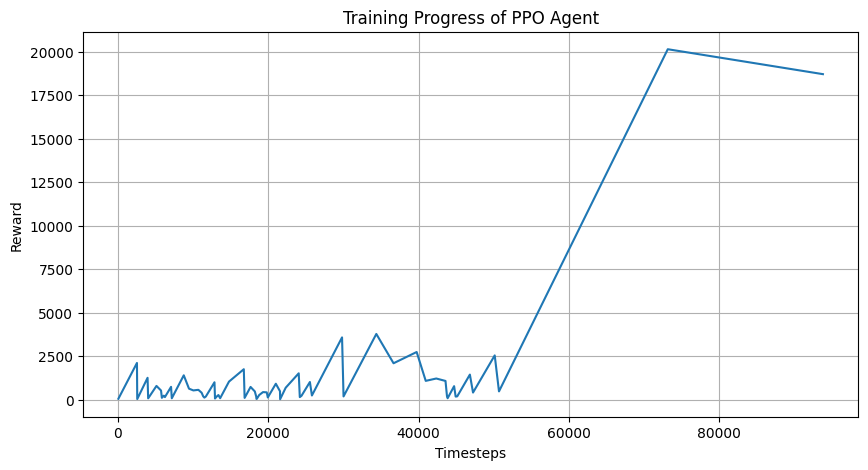

In [11]:
# График на резултати за просечна награда по чекори
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
x, y = ts2xy(load_results(log_dir), 'timesteps')
plt.figure(figsize=(10,5))
plt.plot(x, y)
plt.xlabel("Timesteps")
plt.ylabel("Reward")
plt.title("Training Progress of PPO Agent")
plt.grid(True)
plt.show()

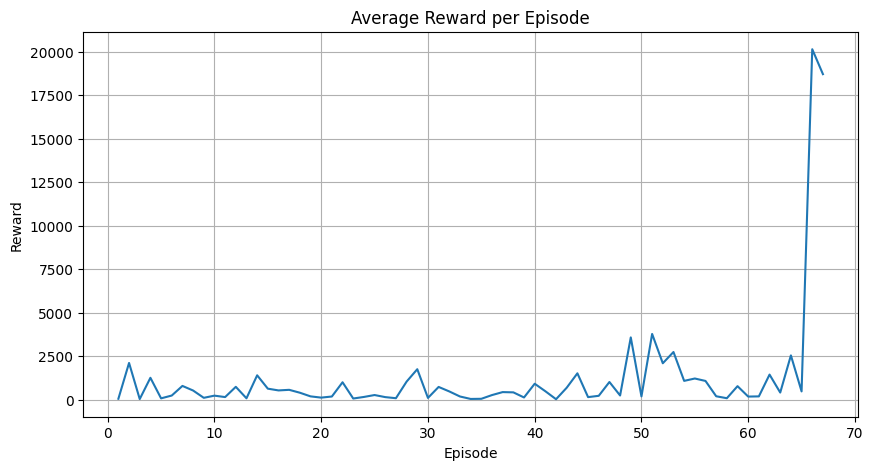

In [12]:
#График на просечна награда по епизода
log_dir = "./logs/"
results = load_results(log_dir)
episodes = range(1, len(results['r']) + 1)
plt.figure(figsize=(10,5))
plt.plot(episodes, results['r'])
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Average Reward per Episode")
plt.grid(True)
plt.show()


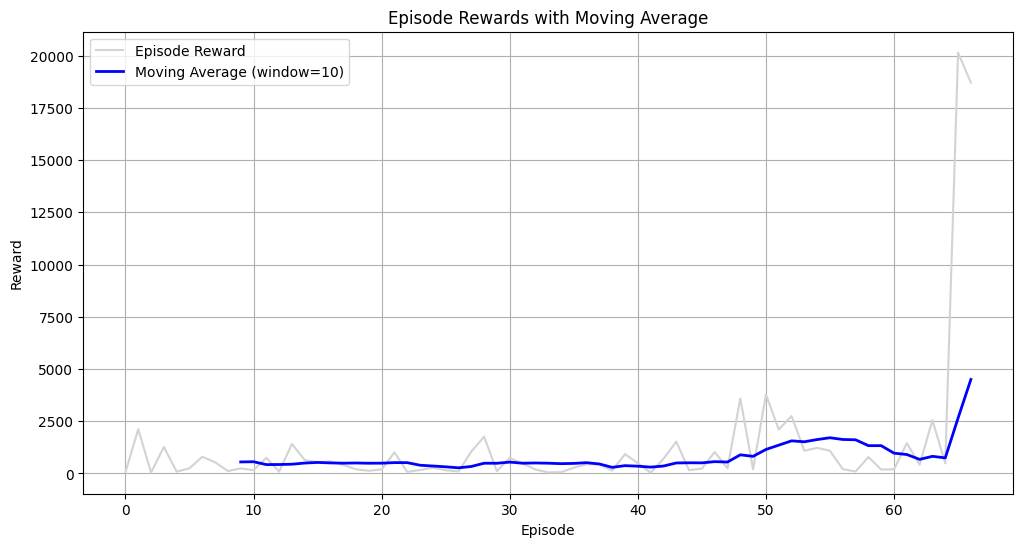

In [13]:
#График на просечна награда по епизода со просен на 10 епизоди

#Вчитување резултати од тренирање
results = load_results(log_dir)
rewards = results['r']

#  Параметар за moving average (просек)
window = 10
moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')

# график
plt.figure(figsize=(12,6))
plt.plot(range(len(rewards)), rewards, color='lightgray', label='Episode Reward')  # оригинални награди
plt.plot(range(window-1, len(rewards)), moving_avg, color='blue', linewidth=2, label=f'Moving Average (window={window})')  # просек
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode Rewards with Moving Average")
plt.legend()
plt.grid(True)
plt.show()


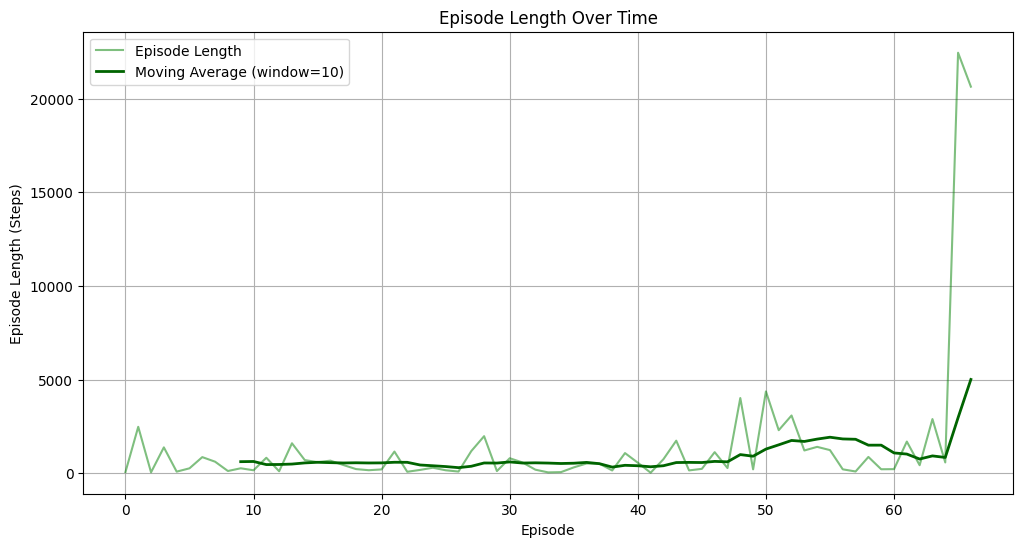

In [14]:
#График за должина на епизода

#  Вчитување резултати од тренирање
results = load_results(log_dir)
episode_lengths = results['l']  # 'l' содржи должина на секоја епизода (колку чекори)

# График на должина на епизода -
plt.figure(figsize=(12,6))
plt.plot(episode_lengths, color='green', alpha=0.5, label='Episode Length')  # оригинални должини

# Moving average за појасен тренд
window = 10
import numpy as np
moving_avg_len = np.convolve(episode_lengths, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(episode_lengths)), moving_avg_len, color='darkgreen', linewidth=2, label=f'Moving Average (window={window})')

plt.xlabel("Episode")
plt.ylabel("Episode Length (Steps)")
plt.title("Episode Length Over Time")
plt.legend()
plt.grid(True)
plt.show()


### Rollout
- **ep_len_mean** – просечна должина на епизода (колку чекори агентот трае пред да заврши епизодата).  
  - 1.900 чекори.  
- **ep_rew_mean** – просечна награда по епизода.  
   ~1.890 по епизода.

### Time
- **fps** – “frames per second”, колку чекори се обработуваат во секунда (~461).  
- **iterations** – број на тренинг итерации на PPO (~98).  
- **time_elapsed** – вкупно поминато време во секунди (~434s).  
- **total_timesteps** – вкупно обработени чекори (~200.704).  

### Train
- **approx_kl** – колку новата политика се разликува од старата.  
  - 0.013 → мали промени, стабилен тренинг.  
- **clip_fraction** – дел од чекорите каде clip механизамот бил активен (~0.16).  
- **clip_range** – максимално дозволена промена во политиката (0.2).  
- **entropy_loss** – мера за разликување на акциите; поголем entropy = повеќе истражување (-2.32). 
- **explained_variance** – колку добро value network ја предвидува наградата (0.593 → средно добро).  
- **learning_rate** – брзина на учење (0.0003).  
- **loss** – загуба при тренингот (0.446).  
- **n_updates** – број на ажурирања на мрежата (970).  
- **policy_gradient_loss** – колку акцијата се движи во правилната насока (-0.000286 → многу мала промена, стабилно).  
- **std** – стандардна девијација на акциите (0.523) 
- **value_loss** – колку value network греши при предвидување на награда (1.14).  


## 4. ВИЗУЕЛИЗАЦИЈА НА ТЕСТ-МОДЕЛ <a id='test'></a>

In [15]:
# Kреирање на околина за тестирање со истите параметри како и околината за тренирање
env = NanoRobotEnv(
    space_size=50,         # големина на просторот
    sigma=5,            # ширина на биомаркерот
    num_obstacles=30,      # број на пречки
    obstacle_radius=3,     # радиус на пречките
    num_cancer_cells=10,   # број на канцер клетки
    step_size=1.5         # големина на чекорот на агентот
)

# Вчитување на зачуваниот модел
import torch
torch._dynamo.reset()
torch._dynamo.disable()
from stable_baselines3 import PPO
model = PPO.load("ppo_nanoagent_f2", custom_objects={"observation_space": env.observation_space,
                                                     "action_space": env.action_space})
model.set_env(env)



fig = go.FigureWidget() # се креира интерактивна фигура со динамичко ажурирање на сцената

# се означуваат канцер клетките од зададената околина како точки во црвена боја
fig.add_scatter3d(x=[c[0] for c in env.cancer_cells],
                   y=[c[1] for c in env.cancer_cells],
                   z=[c[2] for c in env.cancer_cells],
                   mode='markers', marker=dict(size=5, color='red'),
                   name='Cancer Cells')

# се означуваат препреките од зададената околина како точки во црна боја
fig.add_scatter3d(x=[o[0] for o in env.obstacles],
                   y=[o[1] for o in env.obstacles],
                   z=[o[2] for o in env.obstacles],
                   mode='markers', marker=dict(size=5, color='black'),
                   name='Obstacles')

# Поставување на агент
fig.add_scatter3d(x=[env.pos[0]], y=[env.pos[1]], z=[env.pos[2]], #се зема почетната позиција на агентот од околината, се означува со сина точка и се овозможува исцртување на неговата траекторија со сина линија
                   mode='markers+lines',
                   line=dict(color='blue', width=3),
                   marker=dict(size=3, color='blue'),
                   name='Agent Trajectory')

# Подесување на 3Д околината
# се ограничува просторот според големината на околината зададена при тренирање
fig.update_layout(scene=dict(xaxis=dict(range=[0, env.space_size]),
                             yaxis=dict(range=[0, env.space_size]),
                             zaxis=dict(range=[0, env.space_size])))
display(fig)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


FigureWidget({
    'data': [{'marker': {'color': 'red', 'size': 5},
              'mode': 'markers',
              'name': 'Cancer Cells',
              'type': 'scatter3d',
              'uid': '62268ae3-7025-4321-b64a-6645c0df3a77',
              'x': [46.09303858317337, 22.439878406974906, 3.7244464286087853,
                    5.521431110039177, 38.26359833580746, 42.05625180900872,
                    26.8127435960138, 12.395274988456872, 27.049669409108596,
                    49.302130190424265],
              'y': [12.936490732369082, 20.136834082896204, 27.66282573636158,
                    15.79857026680287, 7.9319610325571555, 35.854394259059525,
                    35.09589870299368, 25.833460538161884, 11.602730332820743,
                    22.79146459758098],
              'z': [48.637364826097226, 46.54093966219775, 5.618538123381988,
                    21.79588972505621, 42.2127225978377, 8.60987868965475,
                    27.666626565291715, 18.561302181955302, 

КОНТРОЛЕН ПАНЕЛ ЗА СИМУЛАЦИЈА ВО РЕАЛНО ВРЕМЕ

In [18]:
import threading
import time
import numpy as np
from ipywidgets import Button, HBox, FloatSlider, Label
from IPython.display import display

#  Контроли 
start_button = Button(description="Start")
stop_button = Button(description="Stop")
speed_slider = FloatSlider(value=0.05, min=0.01, max=0.2, step=0.01, description='Speed (s):')
status_label = Label(value="Ready")

controls = HBox([start_button, stop_button, speed_slider, status_label])
display(controls)


running = False # дали е активна симулацијата
trajectory_x, trajectory_y, trajectory_z = [env.pos[0]], [env.pos[1]], [env.pos[2]]
stagnant_steps = 0
max_stagnant = 20  # random push ако долго време нема напредок (после 20 чекори)

# Симулација
def run_simulation():
    global running, trajectory_x, trajectory_y, trajectory_z, stagnant_steps
    running = True # се стартува симулацијата
    obs, _ = env.reset() #се ресетира околината
    done = False
    status_label.value = "Running..."
    
    trajectory_x = [env.pos[0]]
    trajectory_y = [env.pos[1]]
    trajectory_z = [env.pos[2]]
    stagnant_steps = 0 #почетна вредност за чекори во кои агентот не направил акција
    prev_concentration = env.prev_concentration

    start_time = time.time()  # почеток на тајмер

    while running and not done:
        # проверка за 5 секунди
        if time.time() - start_time > 10:
            running = False
            break #симулацијата завршува по 5 секунди

        # стохастички избор на акција
        action, _ = model.predict(obs, deterministic=False)#на секој чекор моделот предвидува акција

        # random push ако е заглавен
        if stagnant_steps > max_stagnant:
            action = np.random.uniform(-1, 1, size=(3,))
            stagnant_steps = 0

        obs, reward, done, _, _ = env.step(action)

        # проверка дали агентот заглавил во локален максимум
        if env.prev_concentration <= prev_concentration:
            stagnant_steps += 1
        else:
            stagnant_steps = 0
        prev_concentration = env.prev_concentration

#се ажурира позицијата на агентот според последната акција
        trajectory_x.append(env.pos[0])
        trajectory_y.append(env.pos[1])
        trajectory_z.append(env.pos[2])
        
#се ажурира траекторијата на агентот според последната акција
        with fig.batch_update():
            fig.data[2].x = trajectory_x
            fig.data[2].y = trajectory_y
            fig.data[2].z = trajectory_z

        time.sleep(speed_slider.value)

    status_label.value = "Stopped" if not running else "Finished"# за крај покажува дали корисникот ја сопрел симулацијата или завршила епизодата

# Stop копче 
def stop_simulation(_):
    global running
    running = False

# повикување на конторлите
start_button.on_click(lambda x: threading.Thread(target=run_simulation).start())
stop_button.on_click(stop_simulation)
